In [1]:
using Distributions
using HypothesisTests
using QuadGK
using Random
using Roots
using StatsBase: ecdf
using StatsPlots
default(fmt=:png)

In [2]:
function simulate(pvaluefunc;
        distx=Normal(),
        disty=Normal(),
        m=20,
        n=20,
        L=10^6
    )
    pval = Vector{Float64}(undef, L)
    nth = Threads.nthreads()
    Xtmp = [Vector{eltype(distx)}(undef, m) for _ in 1:nth]
    Ytmp = [Vector{eltype(distx)}(undef, n) for _ in 1:nth]
    Threads.@threads for i in 1:L
        tid = Threads.threadid()
        X = rand!(distx, Xtmp[tid])
        Y = rand!(disty, Ytmp[tid])
        pval[i] = pvaluefunc(X, Y)
    end
    _pval = ecdf(pval)
    ecdf_pval(x) = _pval(x)
    ecdf_pval
end

function plot_simulation(pvaluefunc;
        distx = Normal(),
        disty = Normal(),
        m = 20,
        n = 20,
        L = 10^5,
        testname = "",
        size = (400, 400),
        kwargs...
    )    
    @show distx
    @show disty
    @show mean(distx)
    @show mean(disty)
    @show std(distx)
    @show std(disty)
    @show prob_of_X_le_Y(distx, disty)
    @show m
    @show n
    
    ecdf_pval = simulate(pvaluefunc; distx, disty, m, n, L)
    
    plot(ecdf_pval, 0, 0.105; label="")
    plot!(identity; label="", ls=:dot, lw=0.5, c=:black)
    plot!(xtick=0:0.01:1, ytick=0:0.01:1, tickfontsize=6)
    plot!(xguide="nominal significance level α",
        yguide="probability of p-value ≤ α")
    title!("$testname", titlefontsize=10)
    plot!(; size, kwargs...)
end

plot_simulation (generic function with 1 method)

In [3]:
function prob_of_X_le_Y(
        distx::ContinuousUnivariateDistribution,
        disty::ContinuousUnivariateDistribution)
    quadgk(y -> cdf(distx, y)*pdf(disty, y), extrema(disty)...)[1]
end

function evenly_matching_shift(distx, disty; a=nothing, b=nothing)
    μ = mean(disty) - mean(distx)
    σ = √(var(distx) + var(disty))
    if isnothing(a)
        a = μ - 3σ
    end
    if isnothing(b)
        b = μ + 3σ
    end
    find_zero(s -> prob_of_X_le_Y(distx + s, disty) - 0.5, (a, b))
end

evenly_matching_shift (generic function with 1 method)

In [4]:
distx = Normal()
disty = Normal(10)
@show s = evenly_matching_shift(distx, disty)
prob_of_X_le_Y(distx + s, disty)

s = evenly_matching_shift(distx, disty) = 10.00000000000512


0.4999999999999999

In [5]:
distx = Gamma(6, 1)
disty = Gamma(1.5, 4)
@show s = evenly_matching_shift(distx, disty)
prob_of_X_le_Y(distx + s, disty)

s = evenly_matching_shift(distx, disty) = -0.8791684156013823


0.5

In [6]:
safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y

"""
    h_brunner_munzel(x, y)

この函数は, x < y のとき 1.0 を, x = y のとき 0.5 を返す.
"""
h_brunner_munzel(x, y) = (x < y) + (x == y)/2

@doc raw"""
    phat_brunner_munzel(X, Y)

まず以下のようにおく:

```math
\begin{aligned}
&
H(x, y) = \begin{cases} 1 & (x < y) \\ 1/2 & (x = y), \end{cases}
\\ &
m = \mathrm{length}(X), \quad
n = \mathrm{length}(Y), \quad
x_i = X[i], \quad
y_j = Y[j]
\end{aligned}
```

この函数は次の $\hat{p}$ を返す:

```math
\hat{p} = \frac{1}{mn}\sum_{i=1}^m \sum_{j=1}^n H(x_i, y_j).
```
"""
phat_brunner_munzel(X, Y) = mean(h_brunner_munzel(x, y) for x in X, y in Y)

@doc raw"""
    statistics_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64);
        p = 1/2
    )

この函数はデータ `X`, `Y` について, Brunner-Munzel検定関係の統計量達を計算する. 詳細は以下の通り.

函数 $H(x, y)$ と $\hat{p}$, $H^x_i$, $H^y_j$, $\bar{H}^x$, $\bar{H}^y$ を次のように定める:

```math
\begin{aligned}
&
m = \mathrm{length}(X), \quad
n = \mathrm{length}(Y), \quad
x_i = X[i], \quad
y_j = Y[j],
\\ &
\hat{p} = \frac{1}{mn}\sum_{i=1}^m \sum_{j=1}^n H(x_i, y_j),
\\ &
H(x, y) = \begin{cases} 1 & (x < y) \\ 1/2 & (x = y), \end{cases}
\\ &
H^x_i = \sum_{j=1}^n H(y_j, x_i), \quad
H^y_j = \sum_{i=1}^m H(x_i, y_j),
\\ &
\bar{H}^x = \frac{1}{m} \sum_{i=1}^m H^x_i = n - n\hat{p},
\\ &
\bar{H}^y = \frac{1}{n} \sum_{j=1}^n H^y_j = m\hat{p}.
\end{aligned}
```

この函数は以下達の named tuple で返す:

```math
\begin{aligned}
&
\mathrm{phat} = 
\hat{p} = \frac{\bar{H}^x - \bar{H}^y + n}{m + n},
\\ &
\mathrm{sx2} =
\hat{\sigma}_x^2 = \frac{1}{n^2}\frac{1}{m-1}\sum_{i=1}^m (H^x_i - \bar{H}^x)^2,
\\ &
\mathrm{sy2} =
\hat{\sigma}_y^2 = \frac{1}{m^2}\frac{1}{n-1}\sum_{j=1}^n (H^y_j - \bar{H}^y)^2,
\\ &
\mathrm{sehat} = 
\widehat{\mathrm{se}} = \sqrt{\frac{\hat{\sigma}_x^2}{m} + \frac{\hat{\sigma}_y^2}{n}}, 
\\ &
\mathrm{tvalue} = t = \frac{\hat{p} - p}{\widehat{\mathrm{se}}},
\\ &
\mathrm{df} =
\nu = 
\frac
{\left(\hat{\sigma}_x^2/m + \hat{\sigma}_y^2/n\right)^2}
{
\dfrac{\left(\hat{\sigma}_x^2/m\right)^2}{m-1} +
\dfrac{\left(\hat{\sigma}_y^2/n\right)^2}{n-1}
},
\\ &
\mathrm{pvalue} =
2\mathrm{ccdf}(\mathrm{TDist}(\nu), |t|).
\end{aligned}
```
"""
function statistics_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64);
        p = 1/2
    )
    m, n = length(X), length(Y)
    for (i, x) in pairs(X)
        Hx[i] = sum(h_brunner_munzel(y, x) for y in Y)
    end
    for (j, y) in pairs(Y)
        Hy[j] = sum(h_brunner_munzel(x, y) for x in X)
    end
    phat = (mean(Hy) - mean(Hx) + n)/(m + n)
    sx2, sy2 = var(Hx)/n^2, var(Hy)/m^2
    sehat = √(sx2/m + sy2/n)
    tvalue = (phat - p)/sehat
    df = safediv((sx2/m + sy2/n)^2, (sx2/m)^2/(m-1) + (sy2/n)^2/(n-1))
    pvalue = (df != 0 && isfinite(df)) ? 2ccdf(TDist(df), abs(tvalue)) : zero(df)
    (; phat, sx2, sy2, sehat, tvalue, df, pvalue)
end

@doc raw"""
    pvalue_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64);
        p = 1/2
    )

この函数はBrunner-Munzel検定のP値 `pvalue` を返す.
"""
function pvalue_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64);
        p = 1/2
    )
    statistics_brunner_munzel(X, Y, Hx, Hy; p).pvalue
end

"""
    tieshift(X::AbstractVector, Y::AbstractVector; p = 1/2)

この函数は `phat_brunner_munzel(X, Y .+ a)` の値が `p` に等しくなる `a` を返す.
"""
function tieshift(X::AbstractVector, Y::AbstractVector; p = 1/2)
    shiftmin = minimum(X) - maximum(Y) - 0.1
    shiftmax = maximum(X) - minimum(Y) + 0.1
    find_zero(a -> phat_brunner_munzel(X, Y .+ a) - p, (shiftmin, shiftmax))
end

@doc raw"""
    brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64),
        Ytmp = similar(Y, Float64);
        p = 1/2,
        α = 0.05,
        maxsplit = 30
    )

この函数はBrunner-Munzel検定を実行する. 詳細は以下の通り.

この函数は `phat`, `sehat`, `tvalue`, `df`, `p`, `pvalue`, `α` および\
以下達の named tuple を返す.

```math
\begin{aligned}
&
\mathrm{confint\_p} = (\text{$p$ の信頼度 $1-\alpha$ の信頼区間}),
\\ &
\mathrm{confint\_shift} = (\text{2つの集団が互角になるようなシフトの信頼度 $1-\alpha$ の信頼区間}),
\\ &
\mathrm{pvalue\_shift} = ($\mathrm{confint\_shift}$ の計算で使われたP値函数),
\\ &
\mathrm{shifthat} = (\text{2つの集団が互角になるようなシフトの点推定値}).
\end{aligned}
```

さらに, $\mathrm{shiftmin}$, $\mathrm{shiftmax}$ はデータから推定されるシフトの下限と上限.

"""
function brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64),
        Ytmp = similar(Y, Float64);
        p = 1/2,
        α = 0.05,
        maxsplit = 30
    )
    (; phat, sehat, tvalue, df, pvalue) = statistics_brunner_munzel(X, Y, Hx, Hy; p)
    
    c = df == 0 ? Inf : quantile(TDist(df), 1 - α/2)
    confint_p = [max(0, phat - c*sehat), min(1, phat + c*sehat)]
    
    function pvalue_shift(a)
        @. Ytmp = Y + a
        pvalue_brunner_munzel(X, Ytmp, Hx, Hy; p)
    end
    shiftmin = minimum(X) - maximum(Y) - 0.1
    shiftmax = maximum(X) - minimum(Y) + 0.1
    shifthat = tieshift(X, Y; p)
    confint_shift = [
        find_zero(a -> pvalue_shift(a) - α, (shiftmin, shifthat))
        find_zero(a -> pvalue_shift(a) - α, (shifthat, shiftmax))
    ]
    
    (; phat, sehat, tvalue, df, p, pvalue, α, confint_p,
        confint_shift, pvalue_shift, shifthat, shiftmin, shiftmax)
end

function show_plot_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64),
        Ytmp = similar(Y, Float64);
        p = 1/2,
        α = 0.05,
        showXY = false,
        kwargs...
    )
    showXY && (@show X Y)
    (; phat, sehat, tvalue, df, p, pvalue, α, confint_p, 
        confint_shift, pvalue_shift, shifthat, shiftmin, shiftmax) =
        brunner_munzel(X, Y, Hx, Hy, Ytmp; p, α)
    pprint((; phat, sehat, tvalue, df, p, pvalue, α, confint_p,
            confint_shift, shifthat))
    println()
    @show median(X) median(Y)
    plot(pvalue_shift, shiftmin, shiftmax; label="")
    vline!([tieshift(X, Y)]; label="", ls=:dash)    
    title!("P-value function of shift")
    plot!(ytick=0:0.05:1)
    plot!(; kwargs...)
end

show_plot_brunner_munzel (generic function with 4 methods)

In [7]:
function make_brunner_munzel_pvaluefunc(m, n; p=1/2)
    nth = Threads.nthreads()
    Hx = [Vector{Float64}(undef, m) for _ in 1:nth]
    Hy = [Vector{Float64}(undef, n) for _ in 1:nth]
    function pvaluefunc(X, Y)
        tid = Threads.threadid()
        pvalue_brunner_munzel(X, Y, Hx[tid], Hy[tid]; p)
    end
    pvaluefunc
end

make_brunner_munzel_pvaluefunc (generic function with 1 method)

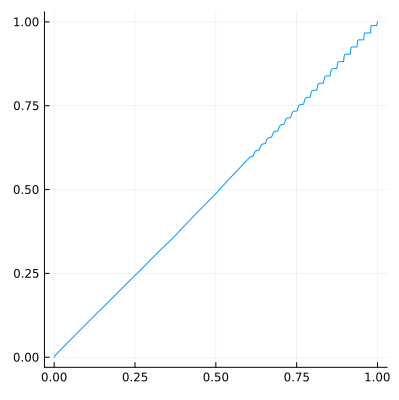

In [8]:
m, n = 20, 20
brunner_munzel_pvaluefunc = make_brunner_munzel_pvaluefunc(m, n)

L = 10^5
pval = zeros(L)
for i in 1:L
    pval[i] = brunner_munzel_pvaluefunc(randn(m), randn(n))
end
_ecdf_pval_bm = ecdf(pval)
ecdf_pval_bm(x) = _ecdf_pval_bm(x)
plot(ecdf_pval_bm, 0, 1; label="", size=(400, 400))

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=1.0)
mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 1.0
std(disty) = 1.0
prob_of_X_le_Y(distx, disty) = 0.5
m = 20
n = 20


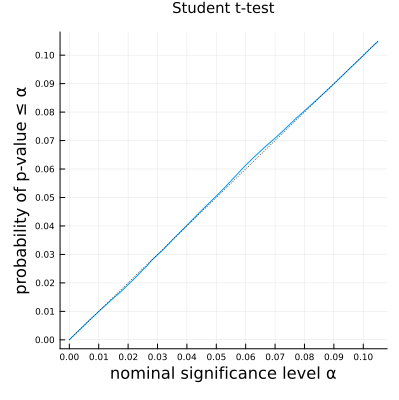

In [9]:
plot_simulation(;
    distx = Normal(),
    disty = Normal(),
    m = 20,
    n = 20,
    testname="Student t-test",
    ) do X, Y
    pvalue(EqualVarianceTTest(X, Y))
end

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=1.0)
mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 1.0
std(disty) = 1.0
prob_of_X_le_Y(distx, disty) = 0.5
m = 20
n = 20


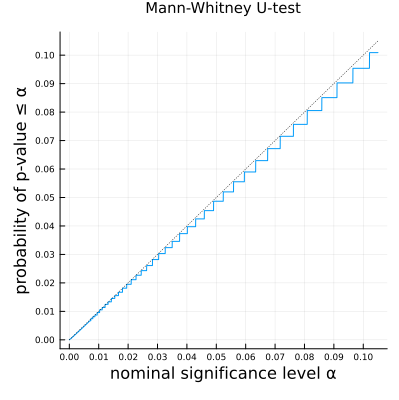

In [10]:
plot_simulation(;
    distx = Normal(),
    disty = Normal(),
    m = 20,
    n = 20,
    testname="Mann-Whitney U-test",
    ) do X, Y
    pvalue(MannWhitneyUTest(X, Y))
end

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=1.0)
mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 1.0
std(disty) = 1.0
prob_of_X_le_Y(distx, disty) = 0.5
m = 20
n = 20


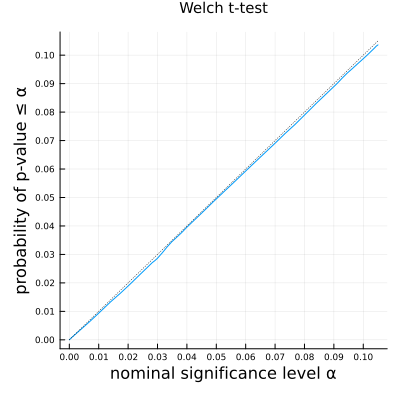

In [11]:
plot_simulation(;
    distx = Normal(),
    disty = Normal(),
    m = 20,
    n = 20,
    testname="Welch t-test",
    ) do X, Y
    pvalue(UnequalVarianceTTest(X, Y))
end

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=1.0)
mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 1.0
std(disty) = 1.0
prob_of_X_le_Y(distx, disty) = 0.5
m = 20
n = 20


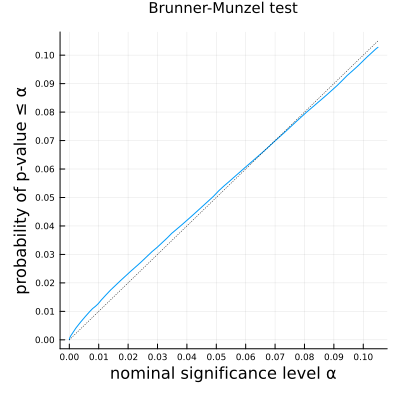

In [12]:
m, n = 20, 20
plot_simulation(
    make_brunner_munzel_pvaluefunc(m, n);
    distx = Normal(),
    disty = Normal(),
    m,
    n,
    testname="Brunner-Munzel test"
)

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=2.0)
mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 1.0
std(disty) = 2.0
prob_of_X_le_Y(distx, disty) = 0.4999999999999862
m = 20
n = 20


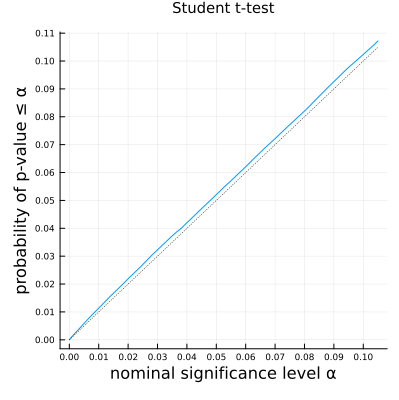

In [13]:
plot_simulation(;
    distx = Normal(0, 1),
    disty = Normal(0, 2),
    m = 20,
    n = 20,
    testname="Student t-test",
    ) do X, Y
    pvalue(EqualVarianceTTest(X, Y))
end

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=2.0)
mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 1.0
std(disty) = 2.0
prob_of_X_le_Y(distx, disty) = 0.4999999999999862
m = 20
n = 20


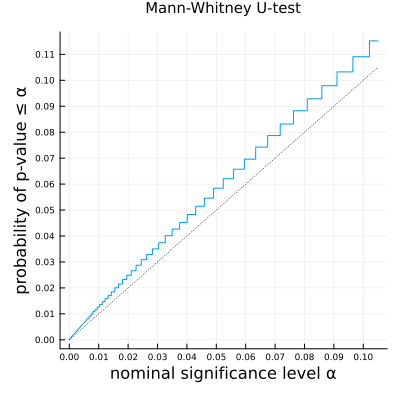

In [14]:
plot_simulation(;
    distx = Normal(0, 1),
    disty = Normal(0, 2),
    m = 20,
    n = 20,
    testname="Mann-Whitney U-test",
    ) do X, Y
    pvalue(MannWhitneyUTest(X, Y))
end

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=2.0)
mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 1.0
std(disty) = 2.0
prob_of_X_le_Y(distx, disty) = 0.4999999999999862
m = 20
n = 20


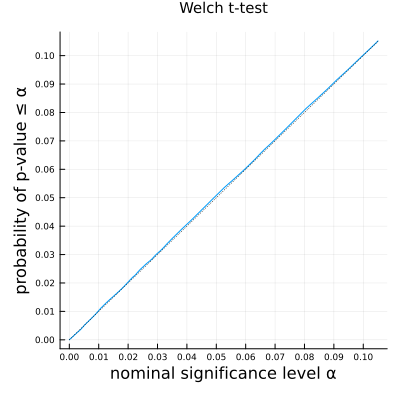

In [15]:
plot_simulation(;
    distx = Normal(0, 1),
    disty = Normal(0, 2),
    m = 20,
    n = 20,
    testname="Welch t-test",
    ) do X, Y
    pvalue(UnequalVarianceTTest(X, Y))
end

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=2.0)
mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 1.0
std(disty) = 2.0
prob_of_X_le_Y(distx, disty) = 0.4999999999999862
m = 20
n = 20


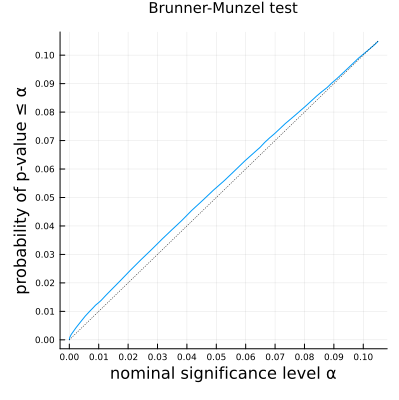

In [16]:
m, n = 20, 20
plot_simulation(
    make_brunner_munzel_pvaluefunc(m, n);
    distx = Normal(0, 1),
    disty = Normal(0, 2),
    m,
    n,
    testname="Brunner-Munzel test"
)

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=2.0)
mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 1.0
std(disty) = 2.0
prob_of_X_le_Y(distx, disty) = 0.4999999999999862
m = 40
n = 20


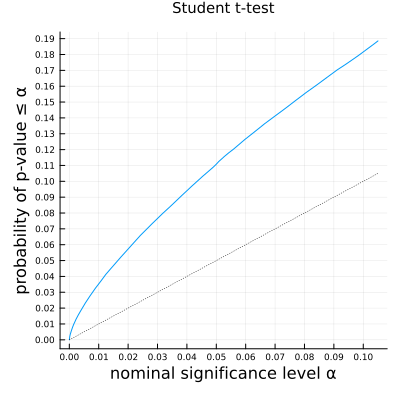

In [17]:
plot_simulation(;
    distx = Normal(0, 1),
    disty = Normal(0, 2),
    m = 40,
    n = 20,
    testname="Student t-test",
    ) do X, Y
    pvalue(EqualVarianceTTest(X, Y))
end

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=2.0)
mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 1.0
std(disty) = 2.0
prob_of_X_le_Y(distx, disty) = 0.4999999999999862
m = 40
n = 20


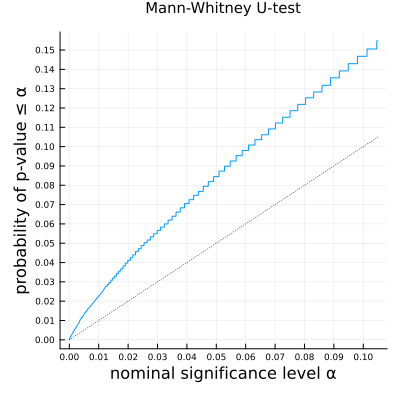

In [18]:
plot_simulation(;
    distx = Normal(0, 1),
    disty = Normal(0, 2),
    m = 40,
    n = 20,
    testname="Mann-Whitney U-test",
    ) do X, Y
    pvalue(MannWhitneyUTest(X, Y))
end

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=2.0)
mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 1.0
std(disty) = 2.0
prob_of_X_le_Y(distx, disty) = 0.4999999999999862
m = 40
n = 20


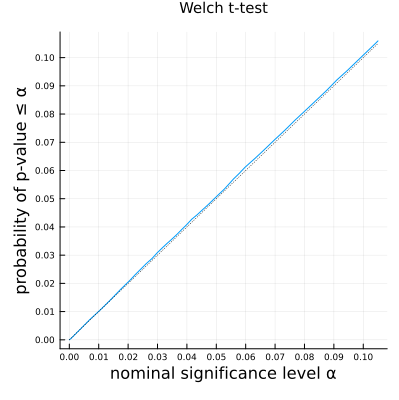

In [19]:
plot_simulation(;
    distx = Normal(0, 1),
    disty = Normal(0, 2),
    m = 40,
    n = 20,
    testname="Welch t-test",
    ) do X, Y
    pvalue(UnequalVarianceTTest(X, Y))
end

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=2.0)
mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 1.0
std(disty) = 2.0
prob_of_X_le_Y(distx, disty) = 0.4999999999999862
m = 40
n = 20


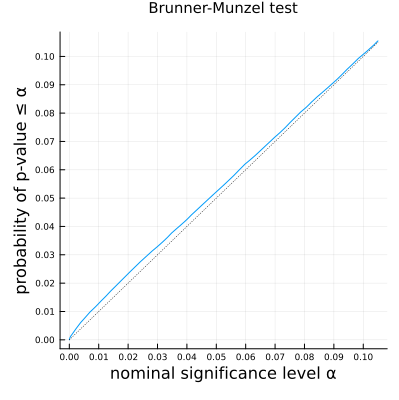

In [20]:
m, n = 40, 20
plot_simulation(
    make_brunner_munzel_pvaluefunc(m, n);
    distx = Normal(0, 1),
    disty = Normal(0, 2),
    m,
    n,
    testname="Brunner-Munzel test"
)

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=2.0)
mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 1.0
std(disty) = 2.0
prob_of_X_le_Y(distx, disty) = 0.4999999999999862
m = 400
n = 200


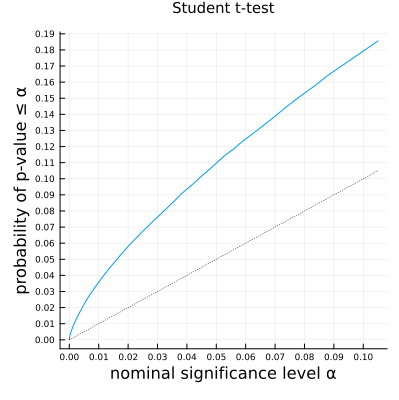

In [21]:
plot_simulation(;
    distx = Normal(0, 1),
    disty = Normal(0, 2),
    m = 400,
    n = 200,
    testname="Student t-test",
    ) do X, Y
    pvalue(EqualVarianceTTest(X, Y))
end

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=2.0)
mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 1.0
std(disty) = 2.0
prob_of_X_le_Y(distx, disty) = 0.4999999999999862
m = 400
n = 200


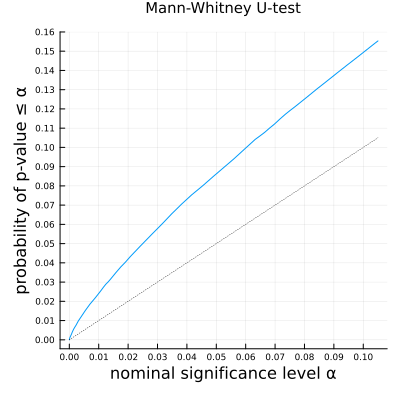

In [22]:
plot_simulation(;
    distx = Normal(0, 1),
    disty = Normal(0, 2),
    m = 400,
    n = 200,
    testname="Mann-Whitney U-test",
    ) do X, Y
    pvalue(MannWhitneyUTest(X, Y))
end

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=2.0)
mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 1.0
std(disty) = 2.0
prob_of_X_le_Y(distx, disty) = 0.4999999999999862
m = 400
n = 200


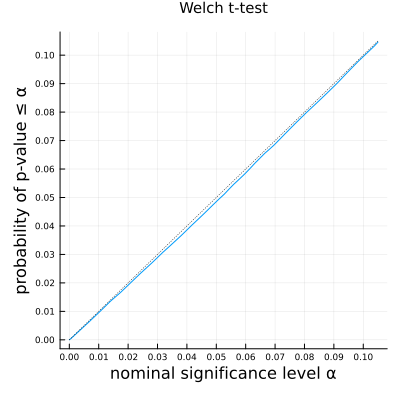

In [23]:
plot_simulation(;
    distx = Normal(0, 1),
    disty = Normal(0, 2),
    m = 400,
    n = 200,
    testname="Welch t-test",
    ) do X, Y
    pvalue(UnequalVarianceTTest(X, Y))
end

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=2.0)
mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 1.0
std(disty) = 2.0
prob_of_X_le_Y(distx, disty) = 0.4999999999999862
m = 400
n = 200


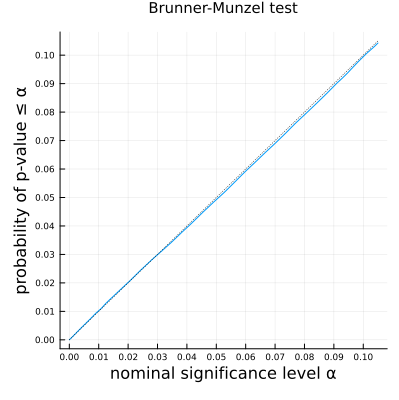

In [24]:
m, n = 400, 200
plot_simulation(
    make_brunner_munzel_pvaluefunc(m, n);
    distx = Normal(0, 1),
    disty = Normal(0, 2),
    m,
    n,
    testname="Brunner-Munzel test"
)

mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 2.23606797749979
std(disty) = 4.47213595499958


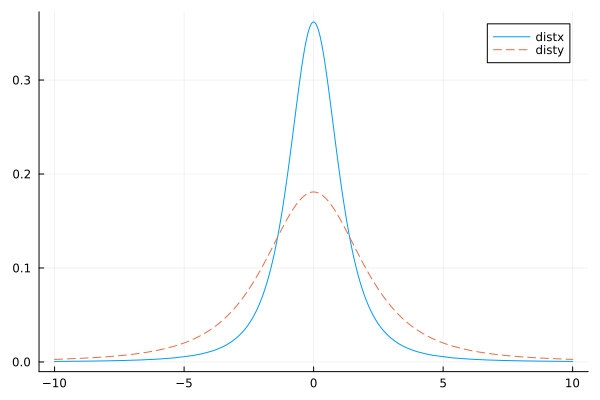

In [25]:
distx = TDist(2.5)
disty = 2TDist(2.5)

@show mean(distx)
@show mean(disty)
@show std(distx)
@show std(disty)

plot(distx, -10, 10; label="distx")
plot!(disty, -10, 10; label="disty", ls=:dash)

distx = TDist{Float64}(ν=2.5)
disty = LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 0.0
σ: 2.0
ρ: TDist{Float64}(ν=2.5)
)

mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 2.23606797749979
std(disty) = 4.47213595499958
prob_of_X_le_Y(distx, disty) = 0.4999999999699046
m = 40
n = 20


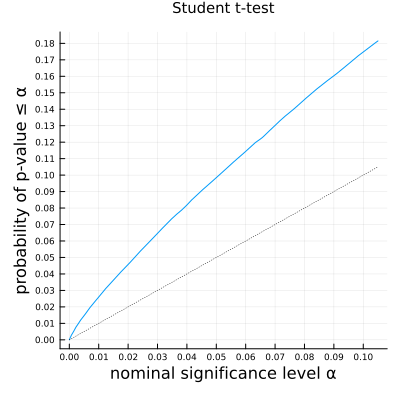

In [26]:
plot_simulation(;
    distx,
    disty,
    m = 40,
    n = 20,
    testname="Student t-test",
    ) do X, Y
    pvalue(EqualVarianceTTest(X, Y))
end

distx = TDist{Float64}(ν=2.5)
disty = LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 0.0
σ: 2.0
ρ: TDist{Float64}(ν=2.5)
)

mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 2.23606797749979
std(disty) = 4.47213595499958
prob_of_X_le_Y(distx, disty) = 0.4999999999699046
m = 40
n = 20


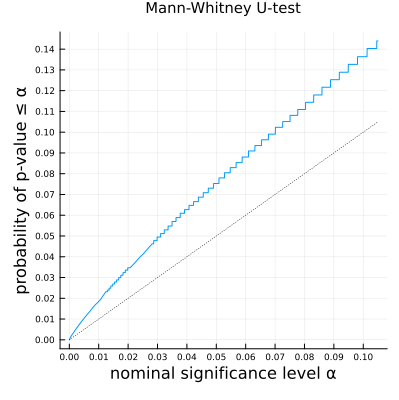

In [27]:
plot_simulation(;
    distx,
    disty,
    m = 40,
    n = 20,
    testname="Mann-Whitney U-test",
    ) do X, Y
    pvalue(MannWhitneyUTest(X, Y))
end

distx = TDist{Float64}(ν=2.5)
disty = LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 0.0
σ: 2.0
ρ: TDist{Float64}(ν=2.5)
)

mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 2.23606797749979
std(disty) = 4.47213595499958
prob_of_X_le_Y(distx, disty) = 0.4999999999699046
m = 40
n = 20


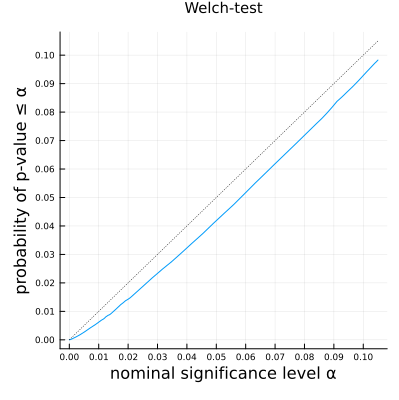

In [28]:
plot_simulation(;
    distx,
    disty,
    m = 40,
    n = 20,
    testname="Welch-test",
    ) do X, Y
    pvalue(UnequalVarianceTTest(X, Y))
end

distx = TDist{Float64}(ν=2.5)
disty = LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 0.0
σ: 2.0
ρ: TDist{Float64}(ν=2.5)
)

mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 2.23606797749979
std(disty) = 4.47213595499958
prob_of_X_le_Y(distx, disty) = 0.4999999999699046
m = 40
n = 20


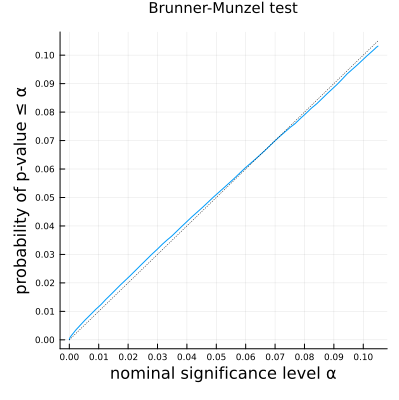

In [29]:
m, n = 40, 20
plot_simulation(
    make_brunner_munzel_pvaluefunc(m, n);
    distx,
    disty,
    m,
    n,
    testname="Brunner-Munzel test"
)

distx = TDist{Float64}(ν=2.5)
disty = LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 0.0
σ: 2.0
ρ: TDist{Float64}(ν=2.5)
)

mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 2.23606797749979
std(disty) = 4.47213595499958
prob_of_X_le_Y(distx, disty) = 0.4999999999699046
m = 400
n = 200


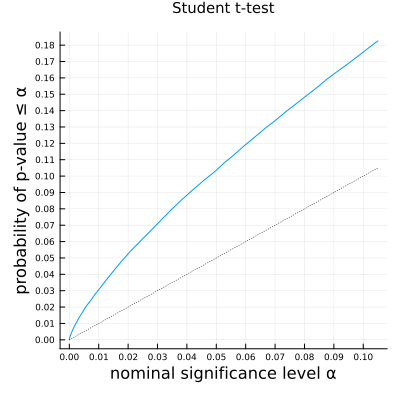

In [30]:
plot_simulation(;
    distx,
    disty,
    m = 400,
    n = 200,
    testname="Student t-test",
    ) do X, Y
    pvalue(EqualVarianceTTest(X, Y))
end

distx = TDist{Float64}(ν=2.5)
disty = LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 0.0
σ: 2.0
ρ: TDist{Float64}(ν=2.5)
)

mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 2.23606797749979
std(disty) = 4.47213595499958
prob_of_X_le_Y(distx, disty) = 0.4999999999699046
m = 400
n = 200


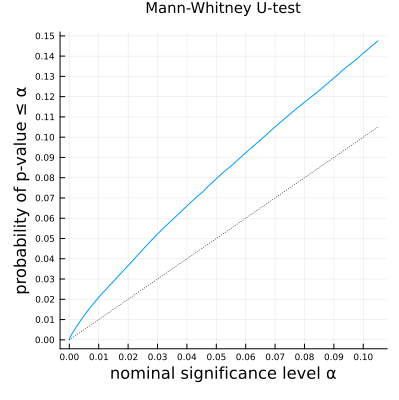

In [31]:
plot_simulation(;
    distx,
    disty,
    m = 400,
    n = 200,
    testname="Mann-Whitney U-test",
    ) do X, Y
    pvalue(MannWhitneyUTest(X, Y))
end

distx = TDist{Float64}(ν=2.5)
disty = LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 0.0
σ: 2.0
ρ: TDist{Float64}(ν=2.5)
)

mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 2.23606797749979
std(disty) = 4.47213595499958
prob_of_X_le_Y(distx, disty) = 0.4999999999699046
m = 400
n = 200


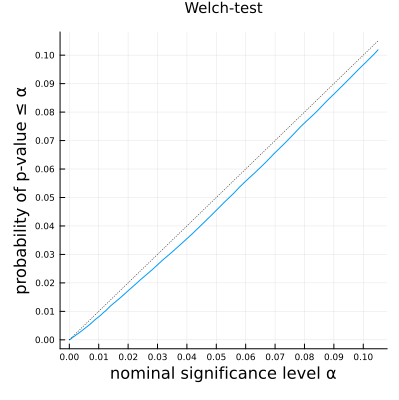

In [32]:
plot_simulation(;
    distx,
    disty,
    m = 400,
    n = 200,
    testname="Welch-test",
    ) do X, Y
    pvalue(UnequalVarianceTTest(X, Y))
end

distx = TDist{Float64}(ν=2.5)
disty = LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 0.0
σ: 2.0
ρ: TDist{Float64}(ν=2.5)
)

mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 2.23606797749979
std(disty) = 4.47213595499958
prob_of_X_le_Y(distx, disty) = 0.4999999999699046
m = 400
n = 200


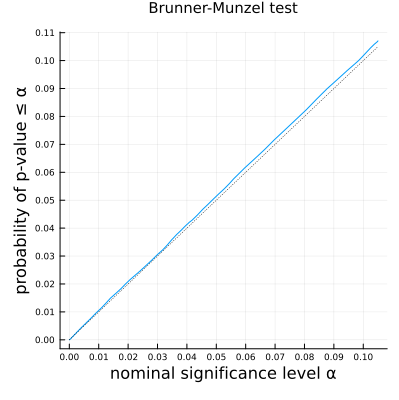

In [33]:
m, n = 400, 200
plot_simulation(
    make_brunner_munzel_pvaluefunc(m, n);
    distx,
    disty,
    m,
    n,
    testname="Brunner-Munzel test"
)

mean(distx) = 6.0
mean(disty) = 6.0
std(distx) = 4.242640687119285
std(disty) = 4.898979485566356
s = -0.2611333017414588


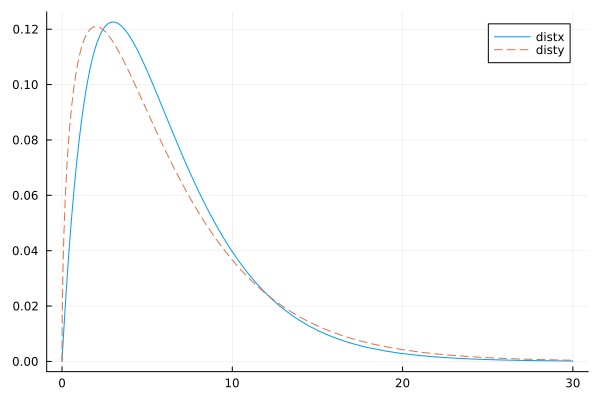

In [34]:
distx = Gamma(2, 3)
disty = Gamma(1.5, 4)
s = evenly_matching_shift(distx, disty)

@show mean(distx)
@show mean(disty)
@show std(distx)
@show std(disty)
@show s

plot(distx, 0, 30; label="distx")
plot!(disty, 0, 30; label="disty", ls=:dash)

distx = Gamma{Float64}(α=2.0, θ=3.0)
disty = Gamma{Float64}(α=1.5, θ=4.0)
mean(distx) = 6.0
mean(disty) = 6.0
std(distx) = 4.242640687119285
std(disty) = 4.898979485566356
prob_of_X_le_Y(distx, disty) = 0.4789491192323665
m = 40
n = 20


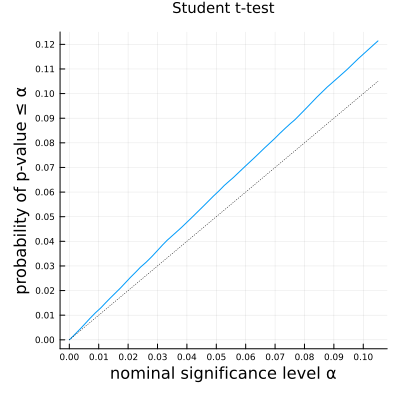

In [35]:
plot_simulation(;
    distx,
    disty,
    m = 40,
    n = 20,
    testname="Student t-test",
    ) do X, Y
    pvalue(EqualVarianceTTest(X, Y))
end

distx = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -0.2611333017414588
σ: 1.0
ρ: Gamma{Float64}(α=2.0, θ=3.0)
)

disty = Gamma{Float64}(α=1.5, θ=4.0)
mean(distx) = 5.7388666982585415
mean(disty) = 6.0
std(distx) = 4.242640687119285
std(disty) = 4.898979485566356
prob_of_X_le_Y(distx, disty) = 0.5
m = 40
n = 20


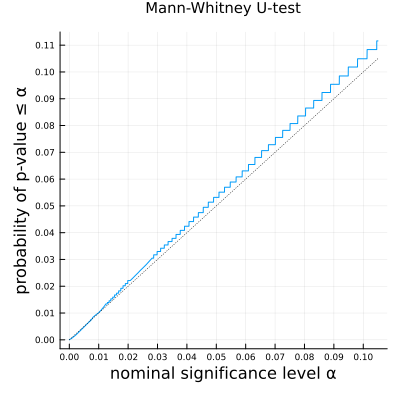

In [36]:
plot_simulation(;
    distx = distx + s,
    disty,
    m = 40,
    n = 20,
    testname="Mann-Whitney U-test",
    ) do X, Y
    pvalue(MannWhitneyUTest(X, Y))
end

distx = Gamma{Float64}(α=2.0, θ=3.0)
disty = Gamma{Float64}(α=1.5, θ=4.0)
mean(distx) = 6.0
mean(disty) = 6.0
std(distx) = 4.242640687119285
std(disty) = 4.898979485566356
prob_of_X_le_Y(distx, disty) = 0.4789491192323665
m = 40
n = 20


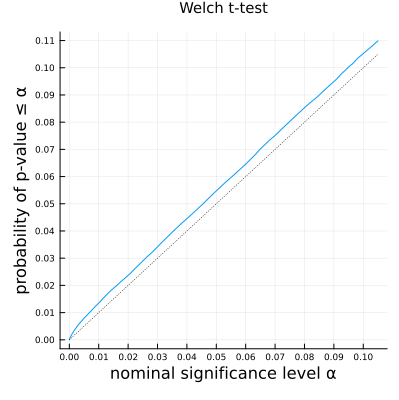

In [37]:
plot_simulation(;
    distx,
    disty,
    m = 40,
    n = 20,
    testname="Welch t-test",
    ) do X, Y
    pvalue(UnequalVarianceTTest(X, Y))
end

distx = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -0.2611333017414588
σ: 1.0
ρ: Gamma{Float64}(α=2.0, θ=3.0)
)

disty = Gamma{Float64}(α=1.5, θ=4.0)
mean(distx) = 5.7388666982585415
mean(disty) = 6.0
std(distx) = 4.242640687119285
std(disty) = 4.898979485566356
prob_of_X_le_Y(distx, disty) = 0.5
m = 40
n = 20


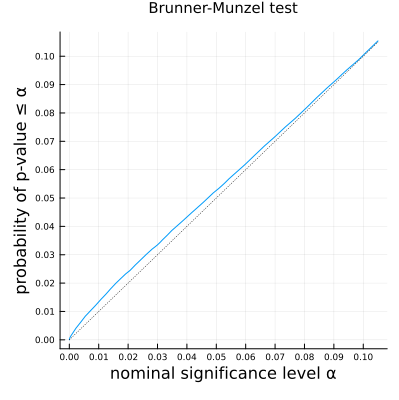

In [38]:
m, n = 40, 20
plot_simulation(
    make_brunner_munzel_pvaluefunc(m, n);
    distx = distx + s,
    disty,
    m,
    n,
    testname="Brunner-Munzel test"
)

distx = Gamma{Float64}(α=2.0, θ=3.0)
disty = Gamma{Float64}(α=1.5, θ=4.0)
mean(distx) = 6.0
mean(disty) = 6.0
std(distx) = 4.242640687119285
std(disty) = 4.898979485566356
prob_of_X_le_Y(distx, disty) = 0.4789491192323665
m = 100
n = 50


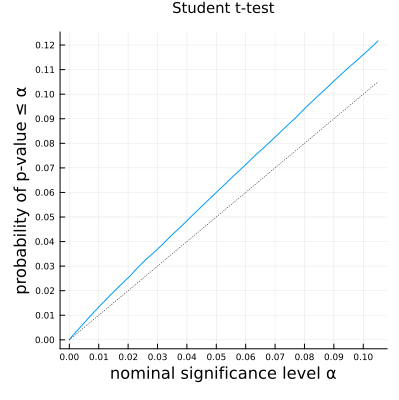

In [39]:
plot_simulation(;
    distx,
    disty,
    m = 100,
    n = 50,
    testname="Student t-test",
    ) do X, Y
    pvalue(EqualVarianceTTest(X, Y))
end

distx = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -0.2611333017414588
σ: 1.0
ρ: Gamma{Float64}(α=2.0, θ=3.0)
)

disty = Gamma{Float64}(α=1.5, θ=4.0)
mean(distx) = 5.7388666982585415
mean(disty) = 6.0
std(distx) = 4.242640687119285
std(disty) = 4.898979485566356
prob_of_X_le_Y(distx, disty) = 0.5
m = 100
n = 50


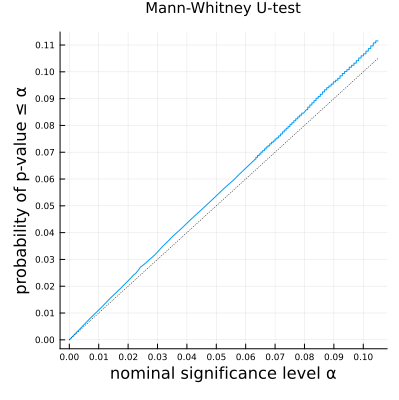

In [40]:
plot_simulation(;
    distx = distx + s,
    disty,
    m = 100,
    n = 50,
    testname="Mann-Whitney U-test",
    ) do X, Y
    pvalue(MannWhitneyUTest(X, Y))
end

distx = Gamma{Float64}(α=2.0, θ=3.0)
disty = Gamma{Float64}(α=1.5, θ=4.0)
mean(distx) = 6.0
mean(disty) = 6.0
std(distx) = 4.242640687119285
std(disty) = 4.898979485566356
prob_of_X_le_Y(distx, disty) = 0.4789491192323665
m = 100
n = 50


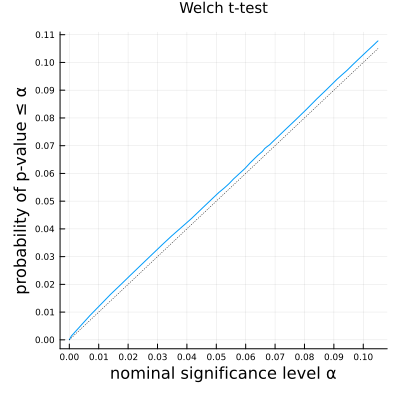

In [41]:
plot_simulation(;
    distx,
    disty,
    m = 100,
    n = 50,
    testname="Welch t-test",
    ) do X, Y
    pvalue(UnequalVarianceTTest(X, Y))
end

distx = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -0.2611333017414588
σ: 1.0
ρ: Gamma{Float64}(α=2.0, θ=3.0)
)

disty = Gamma{Float64}(α=1.5, θ=4.0)
mean(distx) = 5.7388666982585415
mean(disty) = 6.0
std(distx) = 4.242640687119285
std(disty) = 4.898979485566356
prob_of_X_le_Y(distx, disty) = 0.5
m = 100
n = 50


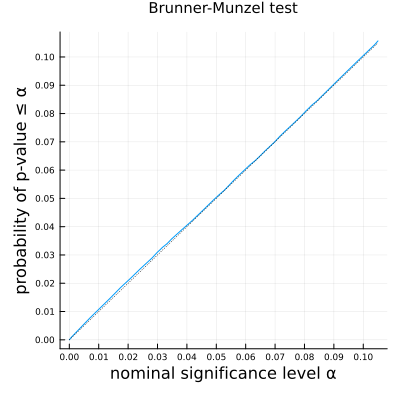

In [42]:
m, n = 100, 50
plot_simulation(
    make_brunner_munzel_pvaluefunc(m, n);
    distx = distx + s,
    disty,
    m,
    n,
    testname="Brunner-Munzel test"
)

mean(distx) = 6.0
mean(disty) = 6.0
std(distx) = 2.449489742783178
std(disty) = 4.898979485566356
s = -0.8791684156013823


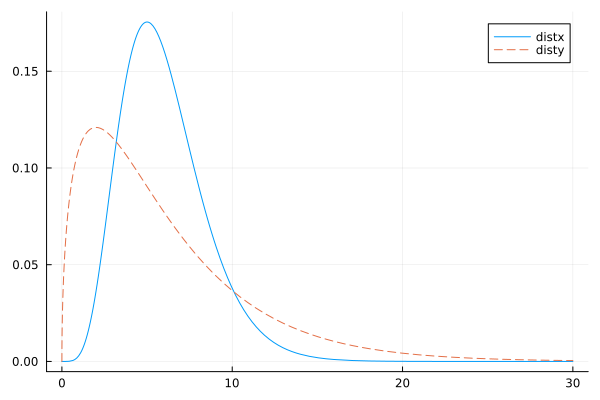

In [43]:
distx = Gamma(6, 1)
disty = Gamma(1.5, 4)
s = evenly_matching_shift(distx, disty)

@show mean(distx)
@show mean(disty)
@show std(distx)
@show std(disty)
@show s

plot(distx, 0, 30; label="distx")
plot!(disty, 0, 30; label="disty", ls=:dash)

distx = Gamma{Float64}(α=6.0, θ=1.0)
disty = Gamma{Float64}(α=1.5, θ=4.0)
mean(distx) = 6.0
mean(disty) = 6.0
std(distx) = 2.449489742783178
std(disty) = 4.898979485566356
prob_of_X_le_Y(distx, disty) = 0.4262213792647898
m = 40
n = 20


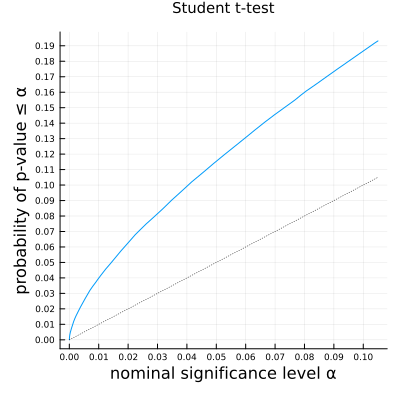

In [44]:
plot_simulation(;
    distx,
    disty,
    m = 40,
    n = 20,
    testname="Student t-test",
    ) do X, Y
    pvalue(EqualVarianceTTest(X, Y))
end

distx = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -0.8791684156013823
σ: 1.0
ρ: Gamma{Float64}(α=6.0, θ=1.0)
)

disty = Gamma{Float64}(α=1.5, θ=4.0)
mean(distx) = 5.120831584398617
mean(disty) = 6.0
std(distx) = 2.449489742783178
std(disty) = 4.898979485566356
prob_of_X_le_Y(distx, disty) = 0.5
m = 40
n = 20


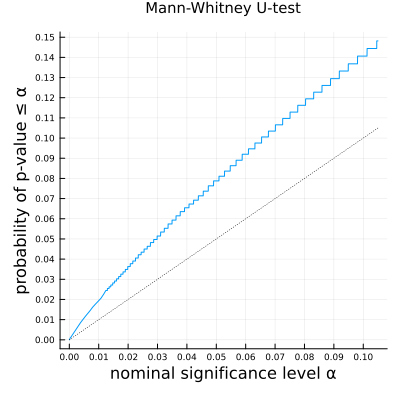

In [45]:
plot_simulation(;
    distx = distx + s,
    disty,
    m = 40,
    n = 20,
    testname="Mann-Whitney U-test",
    ) do X, Y
    pvalue(MannWhitneyUTest(X, Y))
end

distx = Gamma{Float64}(α=6.0, θ=1.0)
disty = Gamma{Float64}(α=1.5, θ=4.0)
mean(distx) = 6.0
mean(disty) = 6.0
std(distx) = 2.449489742783178
std(disty) = 4.898979485566356
prob_of_X_le_Y(distx, disty) = 0.4262213792647898
m = 40
n = 20


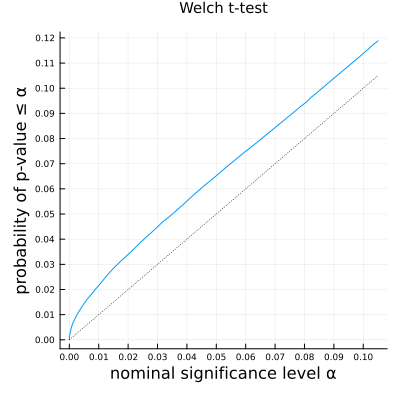

In [46]:
plot_simulation(;
    distx,
    disty,
    m = 40,
    n = 20,
    testname="Welch t-test",
    ) do X, Y
    pvalue(UnequalVarianceTTest(X, Y))
end

distx = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -0.8791684156013823
σ: 1.0
ρ: Gamma{Float64}(α=6.0, θ=1.0)
)

disty = Gamma{Float64}(α=1.5, θ=4.0)
mean(distx) = 5.120831584398617
mean(disty) = 6.0
std(distx) = 2.449489742783178
std(disty) = 4.898979485566356
prob_of_X_le_Y(distx, disty) = 0.5
m = 40
n = 20


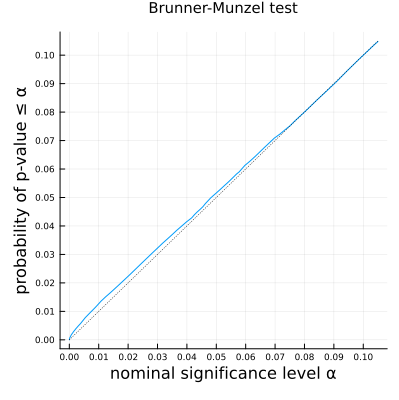

In [47]:
m, n = 40, 20
plot_simulation(
    make_brunner_munzel_pvaluefunc(m, n);
    distx = distx + s,
    disty,
    m,
    n,
    testname="Brunner-Munzel test"
)

distx = Gamma{Float64}(α=6.0, θ=1.0)
disty = Gamma{Float64}(α=1.5, θ=4.0)
mean(distx) = 6.0
mean(disty) = 6.0
std(distx) = 2.449489742783178
std(disty) = 4.898979485566356
prob_of_X_le_Y(distx, disty) = 0.4262213792647898
m = 100
n = 50


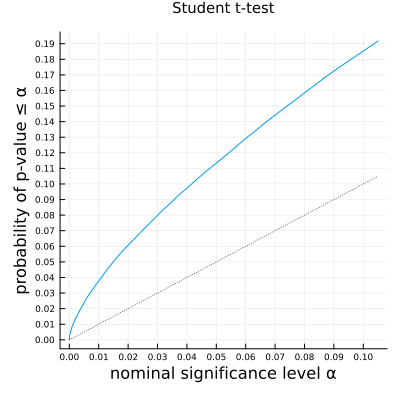

In [48]:
plot_simulation(;
    distx,
    disty,
    m = 100,
    n = 50,
    testname="Student t-test",
    ) do X, Y
    pvalue(EqualVarianceTTest(X, Y))
end

distx = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -0.8791684156013823
σ: 1.0
ρ: Gamma{Float64}(α=6.0, θ=1.0)
)

disty = Gamma{Float64}(α=1.5, θ=4.0)
mean(distx) = 5.120831584398617
mean(disty) = 6.0
std(distx) = 2.449489742783178
std(disty) = 4.898979485566356
prob_of_X_le_Y(distx, disty) = 0.5
m = 100
n = 50


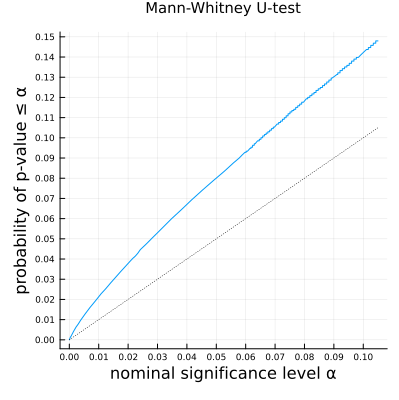

In [49]:
plot_simulation(;
    distx = distx + s,
    disty,
    m = 100,
    n = 50,
    testname="Mann-Whitney U-test",
    ) do X, Y
    pvalue(MannWhitneyUTest(X, Y))
end

distx = Gamma{Float64}(α=6.0, θ=1.0)
disty = Gamma{Float64}(α=1.5, θ=4.0)
mean(distx) = 6.0
mean(disty) = 6.0
std(distx) = 2.449489742783178
std(disty) = 4.898979485566356
prob_of_X_le_Y(distx, disty) = 0.4262213792647898
m = 100
n = 50


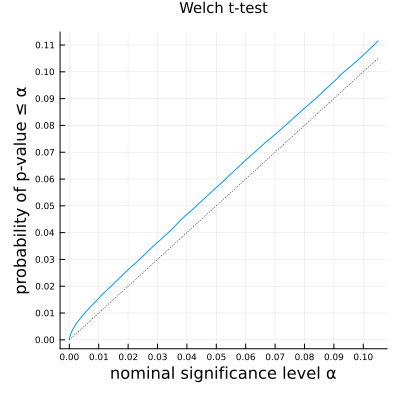

In [50]:
plot_simulation(;
    distx,
    disty,
    m = 100,
    n = 50,
    testname="Welch t-test",
    ) do X, Y
    pvalue(UnequalVarianceTTest(X, Y))
end

distx = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -0.8791684156013823
σ: 1.0
ρ: Gamma{Float64}(α=6.0, θ=1.0)
)

disty = Gamma{Float64}(α=1.5, θ=4.0)
mean(distx) = 5.120831584398617
mean(disty) = 6.0
std(distx) = 2.449489742783178
std(disty) = 4.898979485566356
prob_of_X_le_Y(distx, disty) = 0.5
m = 100
n = 50


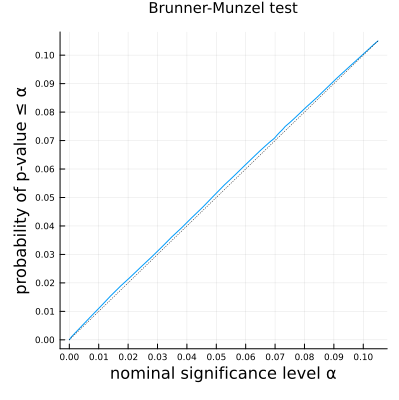

In [51]:
m, n = 100, 50
plot_simulation(
    make_brunner_munzel_pvaluefunc(m, n);
    distx = distx + s,
    disty,
    m,
    n,
    testname="Brunner-Munzel test"
)

distx = Gamma{Float64}(α=6.0, θ=1.0)
disty = Gamma{Float64}(α=1.5, θ=4.0)
mean(distx) = 6.0
mean(disty) = 6.0
std(distx) = 2.449489742783178
std(disty) = 4.898979485566356
prob_of_X_le_Y(distx, disty) = 0.4262213792647898
m = 200
n = 100


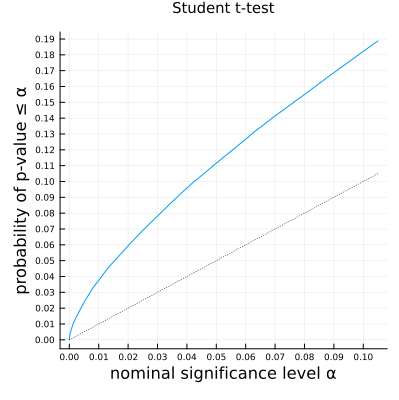

In [52]:
plot_simulation(;
    distx,
    disty,
    m = 200,
    n = 100,
    testname="Student t-test",
    ) do X, Y
    pvalue(EqualVarianceTTest(X, Y))
end

distx = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -0.8791684156013823
σ: 1.0
ρ: Gamma{Float64}(α=6.0, θ=1.0)
)

disty = Gamma{Float64}(α=1.5, θ=4.0)
mean(distx) = 5.120831584398617
mean(disty) = 6.0
std(distx) = 2.449489742783178
std(disty) = 4.898979485566356
prob_of_X_le_Y(distx, disty) = 0.5
m = 200
n = 100


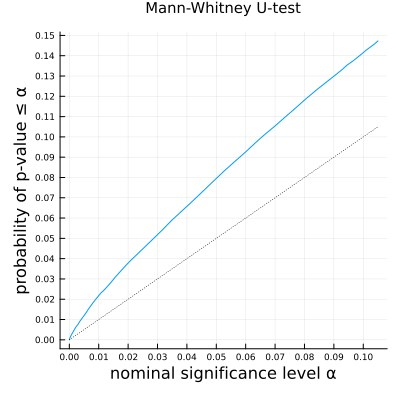

In [53]:
plot_simulation(;
    distx = distx + s,
    disty,
    m = 200,
    n = 100,
    testname="Mann-Whitney U-test",
    ) do X, Y
    pvalue(MannWhitneyUTest(X, Y))
end

distx = Gamma{Float64}(α=6.0, θ=1.0)
disty = Gamma{Float64}(α=1.5, θ=4.0)
mean(distx) = 6.0
mean(disty) = 6.0
std(distx) = 2.449489742783178
std(disty) = 4.898979485566356
prob_of_X_le_Y(distx, disty) = 0.4262213792647898
m = 200
n = 100


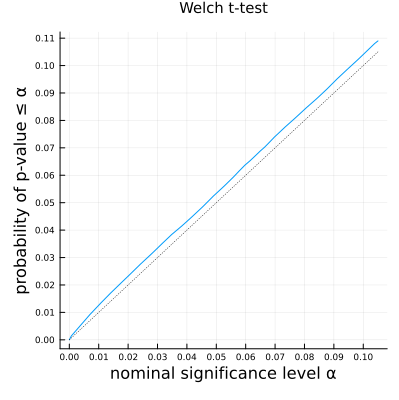

In [54]:
plot_simulation(;
    distx,
    disty,
    m = 200,
    n = 100,
    testname="Welch t-test",
    ) do X, Y
    pvalue(UnequalVarianceTTest(X, Y))
end

distx = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -0.8791684156013823
σ: 1.0
ρ: Gamma{Float64}(α=6.0, θ=1.0)
)

disty = Gamma{Float64}(α=1.5, θ=4.0)
mean(distx) = 5.120831584398617
mean(disty) = 6.0
std(distx) = 2.449489742783178
std(disty) = 4.898979485566356
prob_of_X_le_Y(distx, disty) = 0.5
m = 200
n = 100


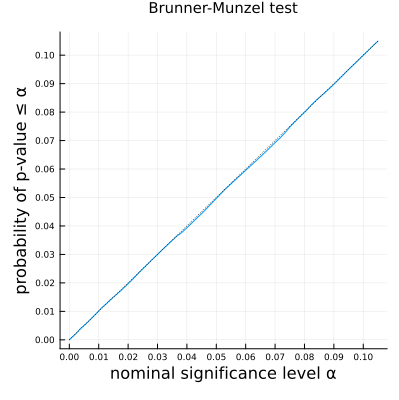

In [55]:
m, n = 200, 100
plot_simulation(
    make_brunner_munzel_pvaluefunc(m, n);
    distx = distx + s,
    disty,
    m,
    n,
    testname="Brunner-Munzel test"
)

mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 2.1611974158950877
std(disty) = 4.3223948317901755
s = -0.8195673943295793


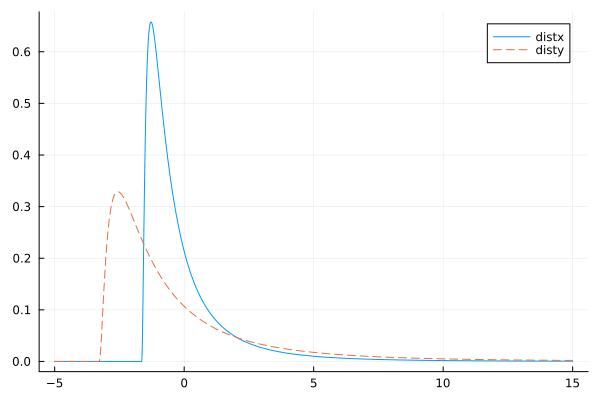

In [56]:
distx = LogNormal()
distx = distx - mean(distx)
disty = 2distx
s = evenly_matching_shift(distx, disty)

@show mean(distx)
@show mean(disty)
@show std(distx)
@show std(disty)
@show s

plot(distx, -5, 15; label="distx")
plot!(disty, -5, 15; label="disty", ls=:dash)

distx = LocationScale{Float64, Continuous, LogNormal{Float64}}(
μ: -1.6487212707001282
σ: 1.0
ρ: LogNormal{Float64}(μ=0.0, σ=1.0)
)

disty = LocationScale{Float64, Continuous, LogNormal{Float64}}(
μ: -3.2974425414002564
σ: 2.0
ρ: LogNormal{Float64}(μ=0.0, σ=1.0)
)

mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 2.1611974158950877
std(disty) = 4.3223948317901755
prob_of_X_le_Y(distx, disty) = 0.3637593318861703
m = 400
n = 200


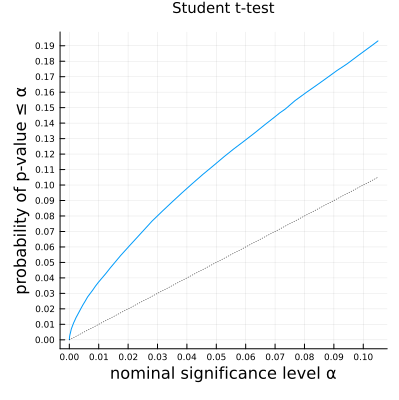

In [57]:
plot_simulation(;
    distx,
    disty,
    m = 400,
    n = 200,
    testname="Student t-test",
    ) do X, Y
    pvalue(EqualVarianceTTest(X, Y))
end

distx = LocationScale{Float64, Continuous, LogNormal{Float64}}(
μ: -2.4682886650297076
σ: 1.0
ρ: LogNormal{Float64}(μ=0.0, σ=1.0)
)

disty = LocationScale{Float64, Continuous, LogNormal{Float64}}(
μ: -3.2974425414002564
σ: 2.0
ρ: LogNormal{Float64}(μ=0.0, σ=1.0)
)

mean(distx) = -0.8195673943295794
mean(disty) = 0.0
std(distx) = 2.1611974158950877
std(disty) = 4.3223948317901755
prob_of_X_le_Y(distx, disty) = 0.5
m = 400
n = 200


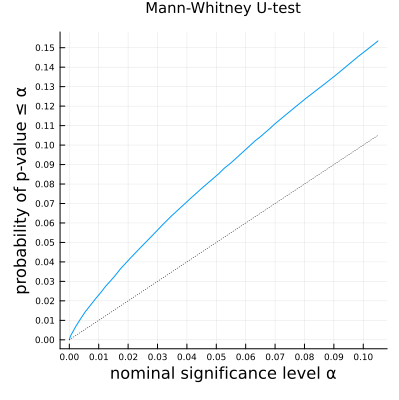

In [58]:
plot_simulation(;
    distx = distx + s,
    disty,
    m = 400,
    n = 200,
    testname="Mann-Whitney U-test",
    ) do X, Y
    pvalue(MannWhitneyUTest(X, Y))
end

distx = LocationScale{Float64, Continuous, LogNormal{Float64}}(
μ: -1.6487212707001282
σ: 1.0
ρ: LogNormal{Float64}(μ=0.0, σ=1.0)
)

disty = LocationScale{Float64, Continuous, LogNormal{Float64}}(
μ: -3.2974425414002564
σ: 2.0
ρ: LogNormal{Float64}(μ=0.0, σ=1.0)
)

mean(distx) = 0.0
mean(disty) = 0.0
std(distx) = 2.1611974158950877
std(disty) = 4.3223948317901755
prob_of_X_le_Y(distx, disty) = 0.3637593318861703
m = 400
n = 200


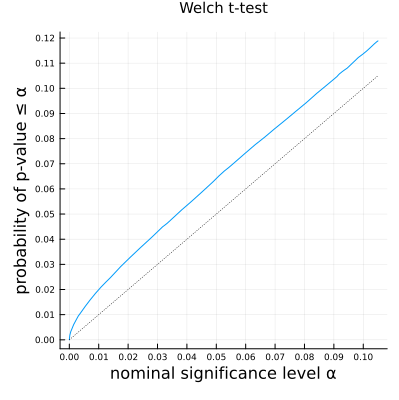

In [59]:
plot_simulation(;
    distx,
    disty,
    m = 400,
    n = 200,
    testname="Welch t-test",
    ) do X, Y
    pvalue(UnequalVarianceTTest(X, Y))
end

distx = LocationScale{Float64, Continuous, LogNormal{Float64}}(
μ: -2.4682886650297076
σ: 1.0
ρ: LogNormal{Float64}(μ=0.0, σ=1.0)
)

disty = LocationScale{Float64, Continuous, LogNormal{Float64}}(
μ: -3.2974425414002564
σ: 2.0
ρ: LogNormal{Float64}(μ=0.0, σ=1.0)
)

mean(distx) = -0.8195673943295794
mean(disty) = 0.0
std(distx) = 2.1611974158950877
std(disty) = 4.3223948317901755
prob_of_X_le_Y(distx, disty) = 0.5
m = 400
n = 200


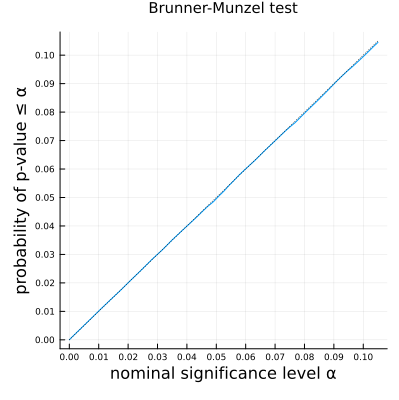

In [60]:
m, n = 400, 200
plot_simulation(
    make_brunner_munzel_pvaluefunc(m, n);
    distx = distx + s,
    disty,
    m,
    n,
    testname="Brunner-Munzel test"
)

distx = LocationScale{Float64, Continuous, LogNormal{Float64}}(
μ: -2.4682886650297076
σ: 1.0
ρ: LogNormal{Float64}(μ=0.0, σ=1.0)
)

disty = LocationScale{Float64, Continuous, LogNormal{Float64}}(
μ: -3.2974425414002564
σ: 2.0
ρ: LogNormal{Float64}(μ=0.0, σ=1.0)
)

mean(distx) = -0.8195673943295794
mean(disty) = 0.0
std(distx) = 2.1611974158950877
std(disty) = 4.3223948317901755
prob_of_X_le_Y(distx, disty) = 0.5
m = 40
n = 20


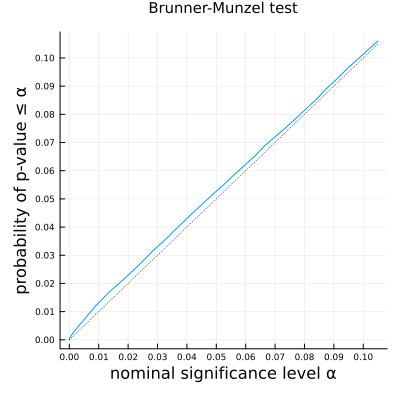

In [61]:
m, n = 40, 20
plot_simulation(
    make_brunner_munzel_pvaluefunc(m, n);
    distx = distx + s,
    disty,
    m,
    n,
    testname="Brunner-Munzel test"
)